In [37]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math 
import scipy.special as sp

In [38]:
# input wave file 
f1 = wave.open('sp01.wav')

# read format information
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params1 = f1.getparams()
nchannels1, sampwidth1, framerate1, nframes1 = params1[:4]
fs1 = framerate1
# read wave data
str_data1 = f1.readframes(nframes1)
# close .wav file
f1.close()

# convert waveform data to an array
x1 = np.fromstring(str_data1, dtype=np.short)

/tmp/ipykernel_1345/149810747.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x1 = np.fromstring(str_data1, dtype=np.short)


In [39]:
# input wave file 
##########f = wave.open('in_SNR15_sp01.wav')
f = wave.open('x.wav')

# read format information
# (nchannels, sampwidth, framerate, nframes, comptype, compname)
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
fs = framerate
# read wave data
str_data = f.readframes(nframes)
# close .wav file
f.close()

# convert waveform data to an array
x = np.fromstring(str_data, dtype=np.short)

/tmp/ipykernel_1345/1102227843.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = np.fromstring(str_data, dtype=np.short)


/tmp/ipykernel_1345/269738662.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  wf.writeframes(wave_data.tostring())


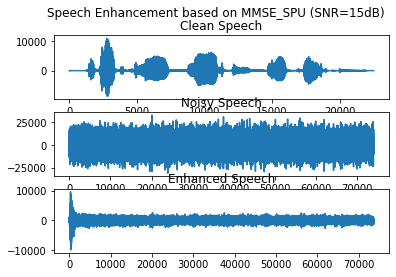

In [42]:
# calculation parameters
len_ = 20 * fs // 1000      # frame size in samples
PERC = 50                   # window overlop in percent of frame
len1 = len_ * PERC // 100    # overlop'length
len2 = len_ - len1          # window'length - overlop'length

# setting default parameters
aa = 0.98
eta = 0.15
Thres = 3
mu = 0.98
c = np.sqrt(np.pi) / 2
qk = 0.3
ksi_min = 10 ** (-25 / 10)   #-25dB

# hamming window
win = np.hamming(len_)
# normalization gain for overlap+add with 50% overlap
winGain = len2 / sum(win)

# setting inital noise
nFFT = 2 * 2 ** 9
j = 1
noise_mean = np.zeros(nFFT)
for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * x[j : j + len_] , nFFT))
    j = j + len_
noise_mu = noise_mean / 5
noise_mu2 = noise_mu ** 2

# initialize various variables
k = 1
img = 1j
x_old = np.zeros(len2)
Nframes = len(x) // len2 - 1
xfinal = np.zeros(Nframes * len2)

# === Start Processing ==== #
for n in range(0, Nframes):

    # Windowing
    insign = win * x[k - 1 : k + len_ - 1]

    # Take fourier transform of frame
    spec = np.fft.fft(insign , nFFT)
    sig = abs(spec)
    sig2 = sig ** 2
    # save the noisy phase information
    theta = np.angle(spec)  

    SNRpos = 10 * np.log10(np.linalg.norm(sig, 2) ** 2 / np.linalg.norm(noise_mu, 2) ** 2)

    # posteriori SNR
    gammak = np.minimum(sig2 / noise_mu2 , 40) 
    
    # decision-direct estimate of a priori SNR   P231 [7.75]
      
    if n == 0:
        ksi = aa + (1 - aa) * np.maximum(gammak - 1 , 0)
    else:
        ksi = aa * Xk_prev / noise_mu2 + (1 - aa) * np.maximum(gammak - 1 , 0)
        # limit ksi to -25 dB 
        ksi = np.maximum(ksi_min , ksi)  

    # --- implement a simple VAD detector --- #
    if SNRpos < Thres:  # Update noise spectrum
        noise_mu2 = mu * noise_mu2 + (1 - mu) * sig2  # Smoothing processing noise power spectrum
        noise_mu = np.sqrt(noise_mu2)

    # [7.40]
    vk = gammak * ksi / (1 + ksi)
    # the modified Bessel function of n order iv(n,x)
    j_0 = sp.iv(0 , vk/2) #modified bessel function of the first kind of real order 
    j_1 = sp.iv(1 , vk/2)    
    C = np.exp(-0.5 * vk)
    A = ((c * (vk ** 0.5)) * C) / gammak      #[7.40] A
    B = (1 + vk) * j_0 + vk * j_1             #[7.40] B
    hw = A * B                                #[7.40]
 
    # get X(w)   [7.197]
    pSAP = (1 - qk) / (1 - qk + qk * (1 + ksi) * np.exp(-vk))
    mmse_speech = sig * hw * pSAP

    # save for estimation of a priori SNR in next frame
    Xk_prev = mmse_speech ** 2  

    # IFFT
    x_phase = mmse_speech * np.exp(img * theta)
    xi_w = np.fft.ifft(x_phase , nFFT).real

    # overlop add
    xfinal[k - 1 : k + len2 - 1] = x_old + xi_w[0 : len1]
    x_old = xi_w[len1 + 0 : len_]

    k = k + len2
    
# save wave file
wf = wave.open('out_SNR15_sp01.wav', 'wb')

# setting parameters
wf.setparams(params)
# set waveform file .tostring()Convert array to data
wave_data = (winGain * xfinal).astype(np.short)
wf.writeframes(wave_data.tostring())
# close wave file
wf.close()

# plot wave
plt.figure(1)
plt.suptitle('Speech Enhancement based on MMSE_SPU (SNR=15dB)')
plt.subplot(311)
plt.plot(x1)
plt.title('Clean Speech')
plt.subplot(312)
plt.plot(x)
plt.title('Noisy Speech')
plt.subplot(313)
plt.plot(winGain * xfinal)
plt.title('Enhanced Speech')
plt.show()